# Price Elastictity Analysis Using Generic Demand Forecasting Models

This notebook is a tutorial on price elasticity analysis using generic time series models. We use a real-life dataset and focus on proper data preparation and pre-filtering.

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pylab as plt
plt.style.use('seaborn-white')
import seaborn as sns
pd.options.mode.chained_assignment = None
plt.rcParams.update({'pdf.fonttype': 'truetype'})

from tabulate import tabulate
import datetime

from sklearn.model_selection import train_test_split
import lightgbm

import platform
print(f'Python {platform.python_version()}')

Python 3.9.1


In [3]:
#
# Helper functions
#
def print_df(df, rows = 10, print_df_mode='psql'):
    if print_df_mode == 'psql':
        print(tabulate(df.head(rows), headers='keys', tablefmt='psql'))
    else:
        display(df.head(rows))
    print(f'{len(df)} rows x {len(df.columns)} columns')

# Data Loading

In [4]:
#
# Data loading
#
data_path = '../../tensor-house-data/pricing/ecommerce-orders'
orders = pd.read_csv(f'{data_path}/ecommerce-sales-orders.csv.zip', compression='zip', parse_dates=['date'])
orders['year'] = orders['date'].dt.year.astype(np.int32)
orders['week'] = orders['date'].dt.isocalendar().week.astype(np.int32)
orders['date'] = orders['date'].dt.date
order_items = pd.read_csv(f'{data_path}/ecommerce-sales-order-items.csv.zip', compression='zip', parse_dates=[])

print_df(orders)
print_df(order_items)

+----+------------+------------+--------+--------+
|    | date       |   order_id |   year |   week |
|----+------------+------------+--------+--------|
|  0 | 2017-10-02 |          0 |   2017 |     40 |
|  1 | 2018-07-24 |          1 |   2018 |     30 |
|  2 | 2018-08-08 |          2 |   2018 |     32 |
|  3 | 2017-11-18 |          3 |   2017 |     46 |
|  4 | 2018-02-13 |          4 |   2018 |      7 |
|  5 | 2017-07-09 |          5 |   2017 |     27 |
|  6 | 2017-04-11 |          6 |   2017 |     15 |
|  7 | 2017-05-16 |          7 |   2017 |     20 |
|  8 | 2017-01-23 |          8 |   2017 |      4 |
|  9 | 2017-07-29 |          9 |   2017 |     30 |
+----+------------+------------+--------+--------+
99441 rows x 4 columns
+----+---------+--------------+------------+
|    |   price |   product_id |   order_id |
|----+---------+--------------+------------|
|  0 |    58.9 |            0 |      85267 |
|  1 |    55.9 |            0 |      64197 |
|  2 |    64.9 |            0 |      1

# Data Cleansing and Pre-Filtering

In this section, we filter out inactive items and items with irregular demand patterns. More specialized forecasting techniques should be used for irregular patterns.

In [7]:
#
# Create a plain demand history layout
#
df = order_items.merge(orders, on='order_id', how='inner')
df['sales_units'] = 1
df.drop(columns=['order_id'], inplace=True)
df = df.groupby(['product_id', 'date']).agg({'price': 'max', 
                                             'year': 'max', 
                                             'week': 'max', 
                                             'sales_units': 'sum'}).reset_index()
print_df(df)
print('Unique products:', len(df['product_id'].unique()))

+----+--------------+------------+---------+--------+--------+---------------+
|    |   product_id | date       |   price |   year |   week |   sales_units |
|----+--------------+------------+---------+--------+--------+---------------|
|  0 |            0 | 2017-06-05 |    55.9 |   2017 |     23 |             1 |
|  1 |            0 | 2017-06-28 |    55.9 |   2017 |     26 |             1 |
|  2 |            0 | 2017-07-27 |    55.9 |   2017 |     30 |             1 |
|  3 |            0 | 2017-08-01 |    58.9 |   2017 |     31 |             1 |
|  4 |            0 | 2017-08-05 |    58.9 |   2017 |     31 |             1 |
|  5 |            0 | 2017-08-10 |    58.9 |   2017 |     32 |             1 |
|  6 |            0 | 2017-09-13 |    58.9 |   2017 |     37 |             1 |
|  7 |            0 | 2018-03-18 |    64.9 |   2018 |     11 |             1 |
|  8 |            0 | 2018-05-18 |    64.9 |   2018 |     20 |             1 |
|  9 |            1 | 2017-04-26 |   239.9 |   2017 

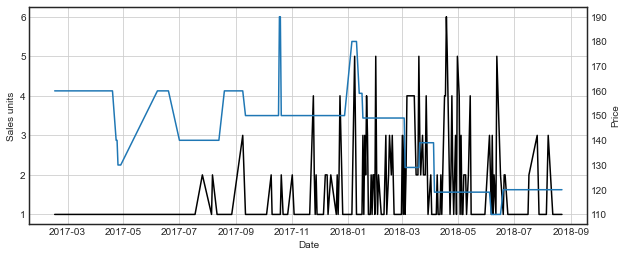

In [8]:
#
# Visualize an example price and sales history for one of the products
#
fig, ax1 = plt.subplots(1, figsize=(10, 4))
df_example_prod = df.query('product_id == 125')

ax1.set_xlabel('Date')
ax1.set_ylabel('Sales units')
ax1.plot(df_example_prod['date'], df_example_prod['sales_units'], c='k')
plt.grid(True)
ax2 = ax1.twinx()
ax2.set_ylabel('Price')
ax2.plot(df_example_prod['date'], df_example_prod['price'])
plt.show()

In [9]:
#
# Filter 1: active products that have, at minimum, ten weeks with at least 1 unit sold
#
df_week_counts = df.groupby(['product_id', 'year', 'week']).size().reset_index()
df_active_products = df_week_counts.groupby(['product_id']).size().reset_index(name='active_weeks').query('active_weeks >= 10')
df_active = df.merge(df_active_products['product_id'], on='product_id', how='inner')

print_df(df_active)
print('Unique products:', len(df_active['product_id'].unique()))

+----+--------------+------------+---------+--------+--------+---------------+
|    |   product_id | date       |   price |   year |   week |   sales_units |
|----+--------------+------------+---------+--------+--------+---------------|
|  0 |            4 | 2017-02-04 |   199.9 |   2017 |      5 |             1 |
|  1 |            4 | 2017-04-25 |   199.9 |   2017 |     17 |             1 |
|  2 |            4 | 2017-05-04 |   199.9 |   2017 |     18 |             1 |
|  3 |            4 | 2017-05-18 |   199.9 |   2017 |     20 |             1 |
|  4 |            4 | 2017-05-20 |   199.9 |   2017 |     20 |             1 |
|  5 |            4 | 2017-07-04 |   199.9 |   2017 |     27 |             1 |
|  6 |            4 | 2017-08-22 |   199.9 |   2017 |     34 |             1 |
|  7 |            4 | 2017-12-19 |   199.9 |   2017 |     51 |             1 |
|  8 |            4 | 2018-01-17 |   199.9 |   2018 |      3 |             1 |
|  9 |            4 | 2018-02-14 |   209.9 |   2018 

+--------------+------------+------------+-------------+--------------+---------------+-----------+----------+
|   product_id | date_min   | date_max   |   n_demands |   demand_std |   demand_mean |       cv2 |      adi |
|--------------+------------+------------+-------------+--------------+---------------+-----------+----------|
|            4 | 2017-02-04 | 2018-03-10 |          12 |     0        |       1       | 0         | 33.25    |
|           10 | 2017-07-16 | 2018-06-29 |          48 |     0.460785 |       1.14583 | 0.161716  |  7.25    |
|           12 | 2017-02-28 | 2018-08-19 |         268 |     1.24732  |       1.8209  | 0.469233  |  2.00373 |
|           13 | 2017-07-18 | 2018-08-25 |         178 |     2.18398  |       2.17978 | 1.00386   |  2.26404 |
|           16 | 2018-03-18 | 2018-06-22 |          18 |     0.323381 |       1.11111 | 0.0847059 |  5.33333 |
|           18 | 2017-06-07 | 2018-08-27 |          18 |     0.514496 |       1.16667 | 0.194478  | 24.7778  |
|

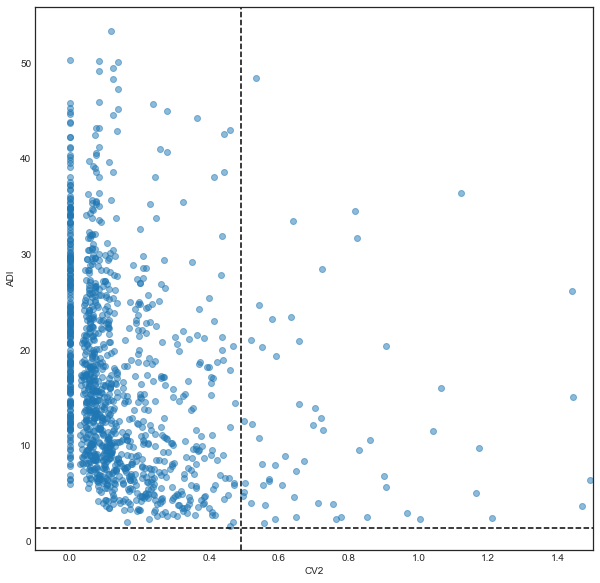

+----+--------------+------------+---------+--------+--------+---------------+
|    |   product_id | date       |   price |   year |   week |   sales_units |
|----+--------------+------------+---------+--------+--------+---------------|
|  0 |            4 | 2017-02-04 |   199.9 |   2017 |      5 |             1 |
|  1 |            4 | 2017-04-25 |   199.9 |   2017 |     17 |             1 |
|  2 |            4 | 2017-05-04 |   199.9 |   2017 |     18 |             1 |
|  3 |            4 | 2017-05-18 |   199.9 |   2017 |     20 |             1 |
|  4 |            4 | 2017-05-20 |   199.9 |   2017 |     20 |             1 |
|  5 |            4 | 2017-07-04 |   199.9 |   2017 |     27 |             1 |
|  6 |            4 | 2017-08-22 |   199.9 |   2017 |     34 |             1 |
|  7 |            4 | 2017-12-19 |   199.9 |   2017 |     51 |             1 |
|  8 |            4 | 2018-01-17 |   199.9 |   2018 |      3 |             1 |
|  9 |            4 | 2018-02-14 |   209.9 |   2018 

In [10]:
#
# Filter 2: Demand type, daily
#
def get_demand_metrics(df, date_column):
    df_dmetrics = df.groupby('product_id').agg(
        date_min=(date_column, 'min'),
        date_max=(date_column, 'max'),
        n_demands=(date_column, 'nunique'),
        demand_std=('sales_units', 'std'), 
        demand_mean=('sales_units', 'mean'))

    df_dmetrics['cv2'] = np.power(df_dmetrics['demand_std'] / df_dmetrics['demand_mean'], 2.0)
    time_delta = df_dmetrics['date_max'] - df_dmetrics['date_min']
    if pd.api.types.is_numeric_dtype(time_delta):
        df_dmetrics['adi'] = time_delta / df_dmetrics['n_demands']
    else:
        df_dmetrics['adi'] = time_delta.dt.days / df_dmetrics['n_demands']
    
    return df_dmetrics

def plot_demand_type(df_demand_metrics):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.scatter(df_demand_metrics['cv2'], df_demand_metrics['adi'], alpha = 0.5)
    ax.axhline(1.32, linestyle='--', color='k')
    ax.axvline(0.49, linestyle='--', color='k')
    ax.set_xlim([-0.1, 1.5])
    ax.set_xlabel('CV2')
    ax.set_ylabel('ADI')
    plt.show()
    
df_dmetrics = get_demand_metrics(df_active, 'date')
print_df(df_dmetrics)
plot_demand_type(df_dmetrics)

non_lumpy_products = df_dmetrics.query('adi < 1.39 or cv2 < 0.49').index
df_active_nonlumpy = df_active[df_active['product_id'].isin(non_lumpy_products)]
print_df(df_active_nonlumpy)
print('Unique products:', len(df_active_nonlumpy['product_id'].unique()))

+----+--------------+---------+---------------+------------+---------+
|    |   product_id |   yweek |   sales_units | date       |   price |
|----+--------------+---------+---------------+------------+---------|
|  0 |            4 |  104889 |             1 | 2017-02-04 |   199.9 |
|  1 |            4 |  104901 |             1 | 2017-04-25 |   199.9 |
|  2 |            4 |  104902 |             1 | 2017-05-04 |   199.9 |
|  3 |            4 |  104904 |             2 | 2017-05-18 |   199.9 |
|  4 |            4 |  104911 |             1 | 2017-07-04 |   199.9 |
|  5 |            4 |  104918 |             1 | 2017-08-22 |   199.9 |
|  6 |            4 |  104935 |             1 | 2017-12-19 |   199.9 |
|  7 |            4 |  104939 |             1 | 2018-01-17 |   199.9 |
|  8 |            4 |  104943 |             2 | 2018-02-14 |   209.9 |
|  9 |            4 |  104946 |             1 | 2018-03-10 |   209.9 |
+----+--------------+---------+---------------+------------+---------+
20288 

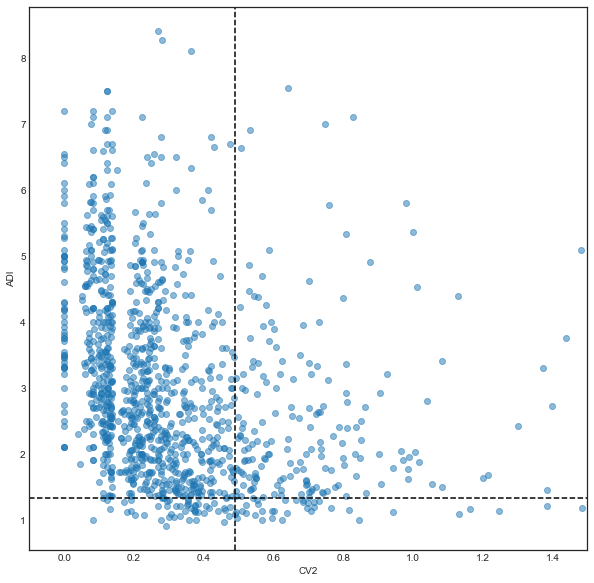

+----+--------------+---------------+------------+---------+
|    |   product_id |   sales_units | date       |   price |
|----+--------------+---------------+------------+---------|
|  0 |            4 |             1 | 2017-02-04 |   199.9 |
|  1 |            4 |             1 | 2017-04-25 |   199.9 |
|  2 |            4 |             1 | 2017-05-04 |   199.9 |
|  3 |            4 |             2 | 2017-05-18 |   199.9 |
|  4 |            4 |             1 | 2017-07-04 |   199.9 |
|  5 |            4 |             1 | 2017-08-22 |   199.9 |
|  6 |            4 |             1 | 2017-12-19 |   199.9 |
|  7 |            4 |             1 | 2018-01-17 |   199.9 |
|  8 |            4 |             2 | 2018-02-14 |   209.9 |
|  9 |            4 |             1 | 2018-03-10 |   209.9 |
+----+--------------+---------------+------------+---------+
16794 rows x 4 columns
Unique products: 1012


In [15]:
#
# For the sake of illustration, we also examine how the demand patters 
# are distributed for weekly aggregates 
#
df_weekly = df_active.copy()
df_weekly['yweek'] = df_weekly['year']*52 + df_weekly['week']
df_weekly = df_weekly.groupby(['product_id', 'yweek']).agg({'sales_units': 'sum', 'date': 'min', 'price': 'mean'}).reset_index()

print_df(df_weekly)

df_dmetrics = get_demand_metrics(df_weekly, 'yweek')
plot_demand_type(df_dmetrics)

non_lumpy_products_weekly = df_dmetrics.query('adi < 1.39 or cv2 < 0.49').index
df_active_nonlumpy_weekly = df_weekly[df_weekly['product_id'].isin(non_lumpy_products_weekly)].drop(columns=['yweek'])
print_df(df_active_nonlumpy_weekly)
print('Unique products:', len(df_active_nonlumpy_weekly['product_id'].unique()))

In [17]:
#
# Filter 3: 
# - Products that changed their price at least three times
# - Each of these prices has at least four days of sales
#
df_active_moving_products = df_active_nonlumpy_weekly.groupby(['product_id', 'price']).agg(n_days = ('date', 'nunique')).query('n_days >= 4').reset_index()

df_active_variable_products = df_active_moving_products.groupby('product_id').agg(n_prices = ('price', 'nunique')).query('n_prices >= 3')
df_active_variable = df_active_nonlumpy_weekly[df_active_nonlumpy_weekly['product_id'].isin(df_active_variable_products.index)]

print_df(df_active_variable, rows=10)
print('Unique products:', len(df_active_variable['product_id'].unique()))

+----+--------------+---------------+------------+---------+
|    |   product_id |   sales_units | date       |   price |
|----+--------------+---------------+------------+---------|
| 39 |           12 |             7 | 2017-02-28 |    89.9 |
| 40 |           12 |             5 | 2017-03-06 |    89.9 |
| 41 |           12 |             4 | 2017-03-13 |    89.9 |
| 42 |           12 |             4 | 2017-03-20 |    89.9 |
| 43 |           12 |             6 | 2017-03-27 |    89.9 |
| 44 |           12 |             7 | 2017-04-03 |    89.9 |
| 45 |           12 |             5 | 2017-04-11 |    89.9 |
| 46 |           12 |            13 | 2017-04-17 |    89.9 |
| 47 |           12 |             7 | 2017-04-24 |    89.9 |
| 48 |           12 |            10 | 2017-05-01 |    89.9 |
+----+--------------+---------------+------------+---------+
1570 rows x 4 columns
Unique products: 48


# Demand Forecasting and Elasticity Analysis

In this section, we fit a LightGBM model and use it to build an elasticity profle for one of the products.

In [18]:
# 
# Features
#
X = df_active_variable[['product_id', 'date', 'price']]
y = df_active_variable[['sales_units']]

# add days to Black Friday
black_fridays = np.array([datetime.datetime(2016, 11, 25), datetime.datetime(2017, 11, 24), datetime.datetime(2018, 11, 23)])
def nearest_future_event(date, events):
    distances = []
    for e in events:
        distances.append(e.date() - date)
    for d in distances:
        if d.days >= 0:
            return d.days
X['days_to_black_friday'] = X['date'].apply(lambda date: nearest_future_event(date, black_fridays))
X['year'] = pd.to_datetime(X['date']).dt.year
X['month'] = pd.to_datetime(X['date']).dt.month
X['week'] = pd.to_datetime(X['date']).dt.isocalendar().week.astype(np.int32)
X['price_log'] = np.log(X['price'])
X.drop(columns=['date', 'price'], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

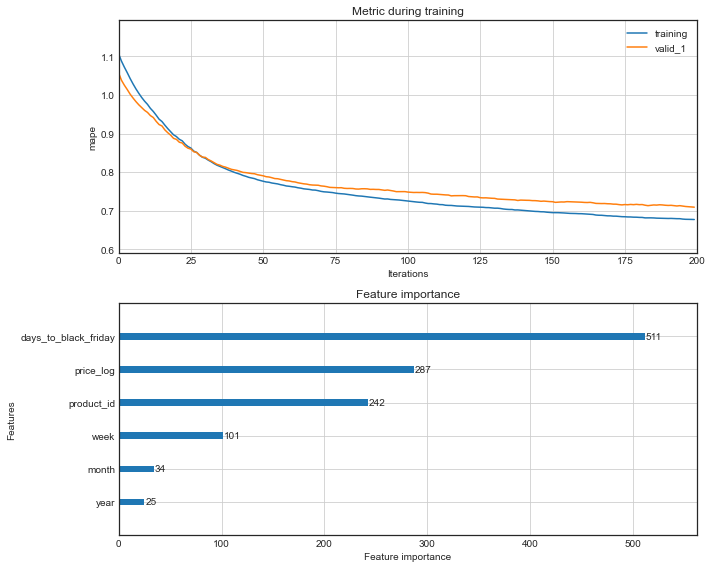

In [20]:
params = {
    'boosting_type': 'gbdt',
    'metric': 'mape',
    'num_leaves': 8 - 1,
    'learning_rate': 0.05,
    'verbosity': -1
}
    
ds_train = lightgbm.Dataset(X_train, y_train)
ds_test = lightgbm.Dataset(X_test, y_test)
    
evals_result = {}
model = lightgbm.train(
              params = params,
              train_set = ds_train, 
              valid_sets = [ds_train, ds_test],
              num_boost_round = 200,
              evals_result = evals_result,
              verbose_eval = False,
)

fig, ax = plt.subplots(2, 1, figsize=(10, 8))
lightgbm.plot_metric(evals_result, metric='mape', ax=ax[0])
lightgbm.plot_importance(model, ax=ax[1])
plt.tight_layout()
plt.savefig('feature-importance.pdf')
plt.show()

In [765]:
print_df(X.query('product_id == 109').head())

+-----+--------------+------------------------+--------+---------+--------+-------------+
|     |   product_id |   days_to_black_friday |   year |   month |   week |   price_log |
|-----+--------------+------------------------+--------+---------+--------+-------------|
| 923 |          109 |                    168 |   2017 |       6 |     23 |     4.78666 |
| 924 |          109 |                    152 |   2017 |       6 |     25 |     4.78666 |
| 925 |          109 |                    148 |   2017 |       6 |     26 |     4.78666 |
| 926 |          109 |                    139 |   2017 |       7 |     27 |     4.78666 |
| 927 |          109 |                    136 |   2017 |       7 |     28 |     4.78666 |
+-----+--------------+------------------------+--------+---------+--------+-------------+
5 rows x 6 columns


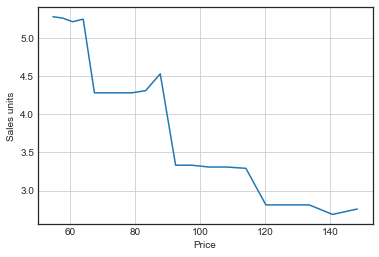

In [25]:
#
# Visualizing the price elasticty function
#
X_validate = np.array([[109, 168, 2017, 6, 23, price_log] for price_log in np.linspace(4, 5, 20)])

sales_units_hat = model.predict(X_validate)

plt.plot(np.exp(X_validate[:, -1]), sales_units_hat)
plt.grid(True)
plt.xlabel('Price')
plt.ylabel('Sales units')
plt.savefig('elasticity-profile.pdf')
plt.show()